# Determining Leatherback Sea Turtle (*Dermochelys coriacea*) Nest Loss on Matura Beach (Trinidad, W.I.)  
##### *Adam Eckert (Leader, nest loss), David Roegner (Tidelines), Montana Hernandez (Nest loss), Valerie Nelson (Nest loss)*
  
    
  

### Project Objectives
##### 1. Determine whether Python could be used to calculate the number of leatherback sea turtle nests lost to tide-caused drowing each year
##### 2. Determine whether a trend in the location of the tide lines could be detected, given the data at hand  
  
  
  

### Project Necessity
* The leatherback is a IUCN Redlisted species, with populations declining around the world. Trinidad is home to one of the largest leatherback nesting colonies in the world.
* As they cannot nest on beaches with offshore protection (e.g., coral reefs, rocky bottoms), leatherback beaches tend to move considerably throughout the season.
* For this reason, leatherbacks frequently select very different locations to nest each time they come ashore to lay their eggs.
* The combination of variable placement and high oceanic activity means that some nesting beaches may experience higher nest loss, due to drowing, than others. 
* The ability to more accurately calculate the number of nests lost to drowning will allow us to better manage the nesting beaches, possibly allowing us to predict and prevent some nest loss.
* This is a project that the Wider Caribbean Sea Turtle Conservation Network (WIDECAST) has been working on for many years. Until now, the only tools tried have been graphical and interactive software based (ArcGIS, QGIS, MapInfo). Python, and DIY code, is the next step in this analysis journey. 

### Data Source
* All data came from WIDECAST
* The data were collected by Garmin eTrex GPS units, and include nest locations (waypoints) and tide line locations (tracklines)
* The data were converted from their original form of Garmin Mapsource (GDB) files to ESRI Shapefiles before analysis

# Package Import and Definition of functions

In [52]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
from shapely.geometry import Point, LineString
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import io
import datetime as dt
import glob
from tqdm import tqdm
import warnings
import fnmatch
from IPython.display import Image

cleanPoints removes outliers by calculating the point's distance from the mean of the rest of the points in the file

In [53]:
def cleanPoints(wpt):
    wpt['lat'] = wpt['geometry'].x
    wpt['lon'] = wpt['geometry'].y
    wpt = wpt[(np.abs(stats.zscore(wpt['lon'])) < 3)]
    return wpt

cleanLine receives a trackline (tideline shapefile) and cleans it. It uses the same technique as cleanPoints

In [54]:
def cleanLine(trk):
    trk=trk.reset_index(drop=True)
    trk1=trk.geometry[0]
    # Turn line into points and add to a list for outlier removal
    coords=list(trk1.coords)
    lon=[]
    lat=[]
    i=0
    
    # Add the lat and long of each coordinate to their respective lists and create a dataframe with those lists
    while i<len(coords):
        lon.append(coords[i][0])
        lat.append(coords[i][1])
        i+=1
    df=pd.DataFrame({'lat':lat,'lon':lon})       
    df['Coordinates']=list(zip(df.lon,df.lat))
    df['Coordinates']=df['Coordinates'].apply(Point)
    # Create new geodataframe with the points and clean them based on distance from mean
    gdf=gpd.GeoDataFrame(df,geometry='Coordinates')
    gdf2 = gdf[(np.abs(stats.zscore(gdf['lon'])) < 2)]
    gdf2= gdf2[(np.abs(stats.zscore(gdf['lat'])) < 2.5)]
    gdf2 = gdf2.reset_index(drop=True)
    # Turn points into a new line
    line=LineString(gdf2['Coordinates'])
    lines=[line]
    df2=pd.DataFrame({'Day':trk['name'][0],'geometry':lines})
    tideLine=gpd.GeoDataFrame(df2,geometry='geometry',crs=4326)
    return tideLine

cleanLineG is similar to cleanLine, but the output has been tweaked slightly to better use for trendline analysis

In [55]:
def cleanLineG(trk1,name):
    coords=list(trk1.coords)
    lon=[]
    lat=[]
    i=0
    while i<len(coords):
        lon.append(coords[i][0])
        lat.append(coords[i][1])
        i+=1
    df=pd.DataFrame({'lat':lat,'lon':lon})
    df['Coordinates']=list(zip(df.lon,df.lat))
    df['Coordinates']=df['Coordinates'].apply(Point)
    gdf=gpd.GeoDataFrame(df,geometry='Coordinates')
    
    gdf2 = gdf[(np.abs(stats.zscore(gdf['lon'])) < 2)]
    gdf2= gdf2[(np.abs(stats.zscore(gdf['lat'])) < 2.5)]
    gdf2 = gdf2.reset_index(drop=True)
    line=LineString(gdf2['Coordinates'])
    lines=[line]
    df2=pd.DataFrame({'name':name,'geometry':lines})
    tideLine=gpd.GeoDataFrame(df2,geometry='geometry',crs=4326)
    return tideLine

distance2 calculates the distance between an initial point and a new point for use in trendline analysis

In [56]:
def distance2(initi,point):
    return -1*(point.x-initi.x) # Multiplying by -1 make a loss show as positive (i.e., tideline moving up beach means ocean is rising and beach is shrinking)

# Determine the trend in high tideline movement, 2011-2019

To calculate the changes in the tidelines, we first must load all the tideline shapefiles and clean them. Once that's done, the date of each tideline is calculated, and the tidelines are grouped by date. The tidelines for each month are then averaged, and those averages are compared to the average of the first month. Finally, all these changes are plotted to see if there is a trend in their movement.

### 1. Import tideline shapfiles and clean them

1a. Create a list of all the shapefiles for the tracks after 2010

In [57]:
# List all the directory names (years) in the Tracks directory and create a new array for the files
years = os.listdir('./Tracks/')
indFiles=[]

# Loop through each directory and select only the shapefiles (.shp) to add to the list. Some data cleaning is also done
for f in years:
    temp=os.listdir('Tracks/'+str(f)+'/')
    temp=['./Tracks/'+str(f)+'/'+ls for ls in temp]
    temp = [x for x in temp if '.shp' in str(x)]
    temp = [y for y in temp if '.shp.' not in str(y)]
    temp = [z for z in temp if 'y10' not in str(z)]
    temp = [a for a in temp if 'e10' not in str(a)]
    temp = [b for b in temp if 't10' not in str(b)]
    indFiles=indFiles+temp

1b. Create a new GeoDataFrame with all the tracks in the data sorted by date

In [58]:
# Suppress warnings about code that will be depreciating
warnings.filterwarnings("ignore", category=FutureWarning)

# Create new GeoDataFrame
allLines= gpd.GeoDataFrame(columns=['name', 'geometry'], geometry='geometry')

# Loop through every file, open them, and add their lines to the new GeoDataFrame
for i in indFiles:
    try:
        trks = gpd.read_file(i)
        if len(trks)>0:
            allLines=allLines.append(trks)
    except ValueError:
        continue

# Select only the tracks that have a date as the name and removes some outlier lines
allLines= allLines[allLines["name"].str.contains("-")==True]
allLines['name'] = pd.to_datetime(allLines['name'])
allLines=allLines.sort_values(by='name')
allLines=allLines.drop_duplicates('name')
allLines=allLines.iloc[1: , :]
allLines=allLines.reset_index(drop=True)

1c. Clean the lines and store them all in a DataFrame

In [59]:
# Suppress warnings
warnings.filterwarnings("ignore")
final=[]
j=0

# Loop through each line, clean them, and create a list of the cleaned lines
for j in tqdm(range(len(allLines))):
    trkg=allLines.loc[j]['geometry']
    c=cleanLineG(trkg,allLines.loc[j]['name'])
    ls=[c]
    final= final+ls

100%|██████████| 890/890 [00:51<00:00, 17.18it/s]


### 2. Place shapefiles into their respective month/year DataFrames

In [60]:
# Take the list of cleaned lines and adds them to a new list based on the year and month of the line creation
jan11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==1]
feb11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==2]
mar11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==3]
apr11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==4]
may11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==5]
jun11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==6]
jul11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==7]
aug11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==8]
sep11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==9]
oct11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==10]
nov11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==11]
dec11=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==12]

jan12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==1]
feb12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==2]
mar12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==3]
apr12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==4]
may12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2011 and pd.to_datetime(x['name'].values[0]).month==5]
jun12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==6]
jul12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==7]
aug12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==8]
sep12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==9]
oct12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==10]
nov12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==11]
dec12=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2012 and pd.to_datetime(x['name'].values[0]).month==12]

jan13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==1]
feb13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==2]
mar13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==3]
apr13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==4]
may13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==5]
jun13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==6]
jul13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==7]
aug13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==8]
sep13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==9]
oct13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==10]
nov13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==11]
dec13=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2013 and pd.to_datetime(x['name'].values[0]).month==12]

jan14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==1]
feb14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==2]
mar14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==3]
apr14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==4]
may14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==5]
jun14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==6]
jul14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==7]
aug14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==8]
sep14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==9]
oct14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==10]
nov14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==11]
dec14=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2014 and pd.to_datetime(x['name'].values[0]).month==12]

jan15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==1]
feb15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==2]
mar15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==3]
apr15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==4]
may15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==5]
jun15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==6]
jul15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==7]
aug15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==8]
sep15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==9]
oct15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==10]
nov15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==11]
dec15=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2015 and pd.to_datetime(x['name'].values[0]).month==12]

jan16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==1]
feb16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==2]
mar16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==3]
apr16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==4]
may16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==5]
jun16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==6]
jul16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==7]
aug16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==8]
sep16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==9]
oct16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==10]
nov16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==11]
dec16=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2016 and pd.to_datetime(x['name'].values[0]).month==12]

jan17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==1]
feb17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==2]
mar17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==3]
apr17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==4]
may17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==5]
jun17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==6]
jul17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==7]
aug17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==8]
sep17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==9]
oct17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==10]
nov17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==11]
dec17=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2017 and pd.to_datetime(x['name'].values[0]).month==12]

jan18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==1]
feb18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==2]
mar18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==3]
apr18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==4]
may18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==5]
jun18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==6]
jul18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==7]
aug18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==8]
sep18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==9]
oct18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==10]
nov18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==11]
dec18=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2018 and pd.to_datetime(x['name'].values[0]).month==12]

jan19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==1]
feb19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==2]
mar19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==3]
apr19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==4]
may19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==5]
jun19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==6]
jul19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==7]
aug19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==8]
sep19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==9]
oct19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==10]
nov19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==11]
dec19=[x for x in final if pd.to_datetime(x['name'].values[0]).year==2019 and pd.to_datetime(x['name'].values[0]).month==12]

### 3. Calculate the changes in tideline locations

3a. Create a list of months for which to do trendline analysis. Only months with 5 or more lines are used.

In [61]:
# Put each list of lines into an array together along with the names of the array
alldata=[jan11,feb11,mar11,apr11,may11,jun11,jul11,aug11,sep11,oct11,nov11,dec11,
         jan12,feb12,mar12,apr12,may12,jun12,jul12,aug12,sep12,oct12,nov12,dec12,
         jan13,feb13,mar13,apr13,may13,jun13,jul13,aug13,sep13,oct13,nov13,dec13,
         jan14,feb14,mar14,apr14,may14,jun14,jul14,aug14,sep14,oct14,nov14,dec14,
         jan15,feb15,mar15,apr15,may15,jun15,jul15,aug15,sep15,oct15,nov15,dec15,
         jan16,feb16,mar16,apr16,may16,jun16,jul16,aug16,sep16,oct16,nov16,dec16,
         jan17,feb17,mar17,apr17,may17,jun17,jul17,aug17,sep17,oct17,nov17,dec17,
         jan18,feb18,mar18,apr18,may18,jun18,jul18,aug18,sep18,oct18,nov18,dec18,
         jan19,feb19,mar19,apr19,may19,jun19,jul19,aug19,sep19,oct19,nov19,dec19]
monthY=['jan11','feb11','mar11','apr11','may11','jun11','jul11','aug11','sep11','oct11','nov11','dec11',
         'jan12','feb12','mar12','apr12','may12','jun12','jul12','aug12','sep12','oct12','nov12','dec12',
         'jan13','feb13','mar13','apr13','may13','jun13','jul13','aug13','sep13','oct13','nov13','dec13',
         'jan14','feb14','mar14','apr14','may14','jun14','jul14','aug14','sep14','oct14','nov14','dec14',
         'jan15','feb15','mar15','apr15','may15','jun15','jul15','aug15','sep15','oct15','nov15','dec15',
         'jan16','feb16','mar16','apr16','may16','jun16','jul16','aug16','sep16','oct16','nov16','dec16',
         'jan17','feb17','mar17','apr17','may17','jun17','jul17','aug17','sep17','oct17','nov17','dec17',
         'jan18','feb18','mar18','apr18','may18','jun18','jul18','aug18','sep18','oct18','nov18','dec18',
         'jan19','feb19','mar19','apr19','may19','jun19','jul19','aug19','sep19','oct19','nov19','dec19']
del alldata[50][1]
alldata2=[]
monthsGood=[]

# Add months to a new list if there are 5 or more lines in that month
for i in range(len(alldata)):
    if len(alldata[i])>4:
        alldata2.append(alldata[i])
        monthsGood.append(monthY[i])
    else:
        alldata2.append(0)
        monthsGood.append(monthY[i])
        

3b. Calculate the average latitude for selected months and assigns the initial latitude for montsh with less than 5 lines

In [62]:
average=[]
for ls in alldata2:
    if ls !=0:
        tomean=[]
        for z in ls:
            try:
                # Find the center of the line
                center=z.centroid.values[0]
                # Check to make sure a point was actually created and add it to a list
                if center != 'EMPTY':
                    tomean.append(center.x)
            except IndexError:
                continue
        # Find the average Latitude of the list for the given month
        average.append(np.average(tomean))
    # If the month has less than 5 lines, the initial point is assigned so there is no change
    else:
        average.append(-61.034890858899516)

3c. Create a GeoDataFrame of the points with a projection that has a unit of meters (UTM Zone 20N)

In [63]:
# Create a longitude list that is the same length as the average to base calculations off of
y1=[]
for y in range(len(average)):
    y1.append(10.637)

# Create a GeoDataFrame of points and reproject it
points=gpd.points_from_xy(average, y1, crs=4326)
points=points.to_crs(epsg=32620)

3d. Calculate the change in latitude from the initial month

In [64]:
# Set the initial point with the first month in the data. Also create an empty array for the distances
initial=points[0]
distance=[]

# Loop through each month's average and calculate the change from the initial point
for point in points:
    val=distance2(initial,point)
    distance.append(val)

3e. Plot the data for the change in tide over time

<function matplotlib.pyplot.show(close=None, block=None)>

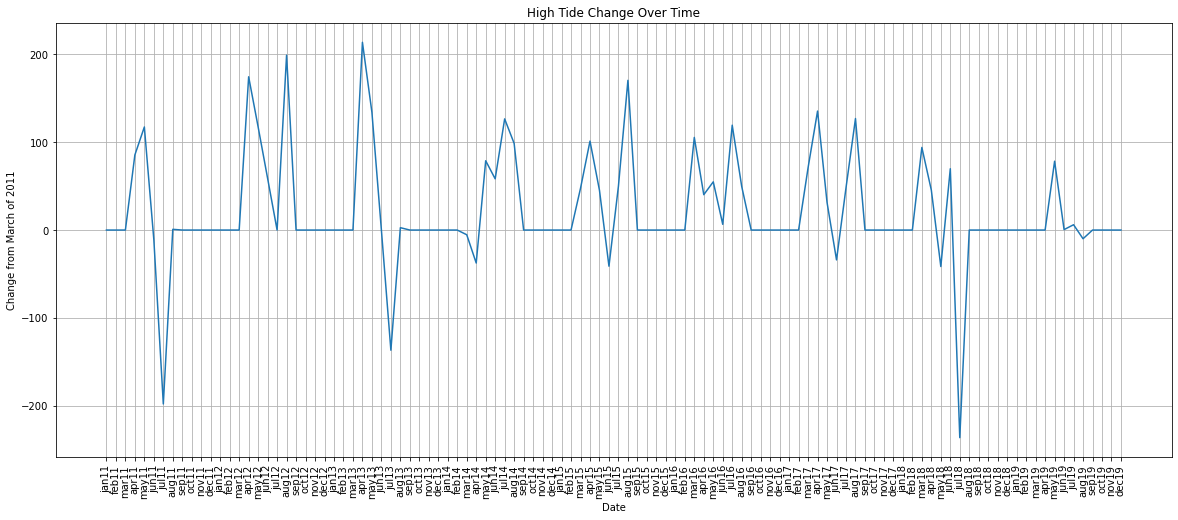

In [65]:
fig,ax=plt.subplots(figsize=(20,8))
ax.plot(monthsGood,distance)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Change from March of 2011')
plt.title('High Tide Change Over Time')
plt.savefig('TrendLine.png')
plt.show

# Determining The Number of Lost Nests, Per Year, on Matura Beach

To find the nests that have drowned, we need to import all the tidelines for one year, buffer those lines to make polygons, then determine how many nests are located within those buffers. Only one year is analyzed at a time to increase processing speed. For each year, the tidelines are imported, cleaned, and projected. Their dates are also determined. The program then iterates through each of the nest files, cleans them, determines their date, and compares the locations of their points to all of the lines that occur within 90 days of the nest file's date. 90 was chosen because that's the average amount of time a leatherback nest incubates for in Trinidad. Once the loops are completed and we have a count of how many times each nest has been drowned, those counts are summed and added to a database for export.

### 1. Ask User for location of data (or define your own pathway), and target Year

The pathway should contain all information up to the parent folder that holds all year folders, and should end with a /

Within the parent folder, there must be two folders: TRK_SHP holds the tide line shapefiles, WPT_SHP holds the nest shapefiles

In [66]:
# Define GitHub Directory for Data
# gh_path = 'C:/Users/aecke/OneDrive/ACTIVE/UIS/Spring_2022/GEOG489/GitHub/GEOG489_Nest_Loss/'

# Ask User for data pathway
# gh_path = input("Where is your data stored? ")
# year_count = input("Which year are you analyzing? ")

##### Use this for the Demo #####
gh_path = './Data_Loss/'
year_count = input("Which year are you analyzing? ")

Which year are you analyzing?  2018


### 2. Load all the tide lines found in the target year's folder

               name                                           geometry    Date
0         01-MAR-18  LINESTRING (-61.03672 10.65176, -61.03661 10.6...  010318
1         01-MAR-18  LINESTRING (-61.03832 10.67863, -61.03827 10.6...  010318
2         01-JUN-18  LINESTRING (-61.03556 10.65182, -61.03542 10.6...  010618
3         01-JUN-18  LINESTRING (-61.03556 10.65182, -61.03542 10.6...  010618
4         02-APR-18  LINESTRING (-61.03766 10.68660, -61.03758 10.6...  020418
..              ...                                                ...     ...
212  ACTIVE LOG 001  LINESTRING (-61.03798 10.67018, -61.03797 10.6...  310318
213  ACTIVE LOG 002  LINESTRING (-61.03788 10.66925, -61.03786 10.6...  310318
214  ACTIVE LOG 003  LINESTRING (-61.03673 10.65919, -61.03673 10.6...  310318
215  ACTIVE LOG 004  LINESTRING (-61.03601 10.65540, -61.03602 10.6...  310318
216  ACTIVE LOG 005  LINESTRING (-61.03607 10.65533, -61.03607 10.6...  310318

[217 rows x 3 columns]


<AxesSubplot:>

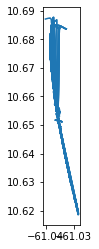

In [67]:
# Suppress warnings about code depreciation
warnings.filterwarnings("ignore", category=FutureWarning)

# Creates the dataframe that will hold all the year's tidelines
trks_any = gpd.GeoDataFrame()

for filename_path in glob.iglob(f'{gh_path}{year_count}/TRK_SHP/*.shp'):
    # print(filename_path)
    # There are some files that throw errors for some reason, so this is a dirty way of ignore those files and continuing with the loop
    try:
        temp_shp = gpd.read_file(filename_path)
    except:
        pass
    
    # Check to make sure there are lines in the shapefile before trying to process them. If there are lines, then the code can continue
    if len(temp_shp) > 0:
        for i in range(len(temp_shp)):
            
            # print(temp_shp)
            # print(temp_shp.iloc[i])
            filename = os.path.basename(filename_path)

            filedate = filename[ :6]
            # print(filedate)
            
            temp_shp['Date'] = filedate
            # print(temp_shp)
            
            trks_any = trks_any.append(temp_shp)

# Reset the index of the new tide line dataframe, then print and plot it for confirmation of sucessful loading
trks_any.reset_index(drop=True, inplace=True)
print(trks_any)
trks_any.plot()

### 3. Clean the tide lines of outliers, project them, and add their dates

3a. Clean and project shapefiles

100%|██████████| 217/217 [00:18<00:00, 11.74it/s]


                Day                                           geometry
0         01-MAR-18  LINESTRING (714763.494 1178155.434, 714775.355...
1         01-MAR-18  LINESTRING (714569.184 1181127.082, 714574.838...
2         01-JUN-18  LINESTRING (714890.882 1178163.085, 714905.865...
3         01-JUN-18  LINESTRING (714890.882 1178163.085, 714905.865...
4         02-APR-18  LINESTRING (714636.301 1182008.452, 714645.101...
..              ...                                                ...
212  ACTIVE LOG 001  LINESTRING (714612.985 1180192.437, 714614.245...
213  ACTIVE LOG 002  LINESTRING (714624.701 1180089.310, 714626.188...
214  ACTIVE LOG 003  LINESTRING (714757.341 1178977.184, 714757.635...
215  ACTIVE LOG 004  LINESTRING (714838.394 1178558.392, 714837.461...
216  ACTIVE LOG 005  LINESTRING (714832.261 1178550.703, 714832.127...

[217 rows x 2 columns]


<AxesSubplot:>

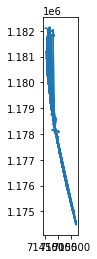

In [68]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Create DataFrame to hold the cleaned tide lines
clean_trks_any = gpd.GeoDataFrame()

# Iterate through the tide lines present in the original DataFrame, pass them to the cleanLine function, then append them to the new DataFrame
for i in tqdm(range(len(trks_any))):
    temp_clean_trk = cleanLine(trks_any.loc[[i]])
    # print(temp_clean_trk)
    clean_trks_any = clean_trks_any.append(temp_clean_trk)

# Reset the new DataFrame's index, project it to the original CRS, then reproject it to Projecte Coordinate System.
clean_trks_any.reset_index(drop=True, inplace=True)
clean_trks_any = clean_trks_any.set_crs(epsg=4326)
clean_trks_any = clean_trks_any.to_crs(epsg=32620)

# Once again, print and plot to confirm success
print(clean_trks_any)
clean_trks_any.plot()

3b. Join the date from the uncleaned lines to the cleaned lines

In [69]:
clean_trks_any = clean_trks_any.merge(trks_any[['Date']], left_index=True, right_index=True)
print(clean_trks_any)

                Day                                           geometry    Date
0         01-MAR-18  LINESTRING (714763.494 1178155.434, 714775.355...  010318
1         01-MAR-18  LINESTRING (714569.184 1181127.082, 714574.838...  010318
2         01-JUN-18  LINESTRING (714890.882 1178163.085, 714905.865...  010618
3         01-JUN-18  LINESTRING (714890.882 1178163.085, 714905.865...  010618
4         02-APR-18  LINESTRING (714636.301 1182008.452, 714645.101...  020418
..              ...                                                ...     ...
212  ACTIVE LOG 001  LINESTRING (714612.985 1180192.437, 714614.245...  310318
213  ACTIVE LOG 002  LINESTRING (714624.701 1180089.310, 714626.188...  310318
214  ACTIVE LOG 003  LINESTRING (714757.341 1178977.184, 714757.635...  310318
215  ACTIVE LOG 004  LINESTRING (714838.394 1178558.392, 714837.461...  310318
216  ACTIVE LOG 005  LINESTRING (714832.261 1178550.703, 714832.127...  310318

[217 rows x 3 columns]


### 4. Find all nests that have been submerged by any tide line during their incubation period (90 days)

4a. Initialize dataframe to hold the years, their nests lost, and their total nests. Will later hold the percent lost.

User input works like this:
1. If the user is only running one year, an empty DataFrame is created
2. If the user is running multiple years, and this is the first run/year, an empty DataFrame is created
3. If the user is running multiple years, and this is not the first run/year, the DataFrame is not created so that the new year's data can be appended to the existing data

In [70]:
while 1:
    multiRun = input('Will you be running one year, or multiple years? (One, Multi) ')
    if multiRun.lower() == 'one':
        full_total_Date_Losses_df = pd.DataFrame(columns = ['Year', 'Nests_Lost', 'Total_Nests'])
        break
    elif multiRun.lower() == 'multi':
        firstRun = input('Is this your first run? (Yes/No) ')
        if firstRun.lower() == 'yes':
            full_total_Date_Losses_df = pd.DataFrame(columns = ['Year', 'Nests_Lost', 'Total_Nests'])
            break
        elif firstRun.lower() == 'no':
            break
    else:
        print('Enter only one of the choices in ().')
        continue

Will you be running one year, or multiple years? (One, Multi)  nes


Enter only one of the choices in ().


Will you be running one year, or multiple years? (One, Multi)  multi
Is this your first run? (Yes/No)  no


4b. Load nests file, clean it, add its date, find all lines that are within 90 days of its date of laying, determine number of nests lost

In [71]:
# Load nests file
total_Date_Losses_df = pd.DataFrame()
total_Nest_Count = 0

# This is used as a counter to show progress, because tqdm doesn't work with glob
# The total number of nest files is around 100
ncount = 1

# Find the total number of nest files to be iterated through
nest_file_count = len(fnmatch.filter(os.listdir(f'{gh_path}{year_count}/WPT_SHP/'), '*.shp'))

# Iterate through every shapefile in the folder that contains the nest files
for filename_path in tqdm(glob.iglob(f'{gh_path}{year_count}/WPT_SHP/*.shp'), total=nest_file_count):
    # print(ncount) # Poor-man's progress bar
    
    # Load nests file, project it to UTM Zone 20N to match tide lines
    temp_shp_wpt = gpd.read_file(filename_path)
    if temp_shp_wpt.crs == None:
        temp_shp_wpt = temp_shp_wpt.set_crs(epsg=4326)
    temp_shp_wpt = temp_shp_wpt.to_crs(epsg=32620)

    # Pull the nest lay date from the name of the file and assign it to a date column in the nests geodataframe
    filename_wpt = os.path.basename(filename_path)
    filedate_wpt = filename_wpt[ :6]
    temp_shp_wpt['Date'] = filedate_wpt
    # print(f'Current date = {filedate_wpt}')
    
    # Clean the nests GDF of any outliers
    clean_wpt = cleanPoints(temp_shp_wpt)

    # Check the clean was successful
    # print(temp_shp_wpt)
    # print(clean_wpt)
    
    # Check to see if there are points in the clean nests geodataframe
    if len(clean_wpt) > 0:
        # Count the total number of nests in the file
        nest_count = len(clean_wpt)
        
        # Create a variable that holds the date for this nest file, then create an actual Python Date variable
        wpt_date = filedate_wpt
        temp_wpt_date = dt.date(int(f'20{wpt_date[4:6]}'), int(wpt_date[2:4]), int(wpt_date[ :2]))

        # Initialize two variables, one to hold the total number of nests lost over the incubation period, the other to hold the incubation period
        totalCount = 0
        incubation_time = 90

        # Begin loop to determine nest loss
        for i in range(incubation_time):

            # Determine which date the nest line should come from, then convert it to a string for comparison later
            temp_wpt_date90 = temp_wpt_date + dt.timedelta(days=i)
            temp_wpt_date90_str = temp_wpt_date90.strftime('%d%m%y')

            # Iterate through the tracks within each date
            for x in range(len(clean_trks_any)):
                
                # Check if there is a track for the target day
                if clean_trks_any.at[x, 'Date'] == temp_wpt_date90_str: 
                    
                    # Pull the track and assign it to a variable
                    tideline = clean_trks_any.iloc[[x]]

                    # Create a flat cap, one-sided buffer of 50 meters to the east of the line, and a flat cap, one-sided buffer of 2 meters to the west of the line
                    lrgBuff = tideline.buffer(-50, cap_style=2, single_sided=True)
                    smlBuff = tideline.buffer(2, cap_style=2, single_sided=True)

                    # Determine how many nests are loacted within each buffer
                    lrgContains = ((lrgBuff.contains(clean_wpt))).tolist()
                    smlContains = ((smlBuff.contains(clean_wpt))).tolist()

                    # Sum the counts to find the total number of nests within buffers
                    count = lrgContains.count(True) + smlContains.count(True)
                    totalCount = totalCount + count

                    # Create a tuple, then a DataFrame, that contains the Lay date and the number of nests lost from that day
                    Date_Losses = [(wpt_date, totalCount)]
                    Date_Losses_df = pd.DataFrame.from_records(Date_Losses, columns=['Lay_Date', 'Nests_Lost'])

        # print(ncount)
        # print(Date_Losses_df)
        total_Date_Losses_df = total_Date_Losses_df.append(Date_Losses_df)
        ncount += 1
        total_Nest_Count += nest_count
print(total_Date_Losses_df)

# Count the total number of nests lost that year and append it to another dataframe, which will hold all the lossess from all the years
year_loss_total = total_Date_Losses_df['Nests_Lost'].sum()
full_total_Date_Losses = [{'Year': year_count, 'Nests_Lost': year_loss_total, 'Total_Nests': total_Nest_Count}]
full_total_Date_Losses_df = full_total_Date_Losses_df.append(full_total_Date_Losses, ignore_index = True)
print(full_total_Date_Losses_df)

100%|██████████| 107/107 [01:18<00:00,  1.36it/s]

   Lay_Date  Nests_Lost
0    010618           8
0    010618           0
0    020418           6
0    020418          10
0    020518          19
..      ...         ...
0    290318           6
0    300518           6
0    300518           2
0    310318           4
0    310318           0

[93 rows x 2 columns]
   Year Nests_Lost Total_Nests  Percent_Loss
0  2010       1618        9607     16.841886
1  2018        305        3192           NaN


4c. If there is only one entry in the DataFrame, calculate percent loss for the first (only) entry. Otherwise, iterate through entries and calculate percent loss for each entry.

In [72]:
if len(full_total_Date_Losses_df) > 1:
    for x in tqdm(range(len(full_total_Date_Losses_df))):
        full_total_Date_Losses_df.at[x, 'Percent_Loss'] = (int(full_total_Date_Losses_df.at[x, 'Nests_Lost']) / int(full_total_Date_Losses_df.at[x, 'Total_Nests']) * 100)
else:
    full_total_Date_Losses_df['Percent_Loss'] = (int(full_total_Date_Losses_df.at[0, 'Nests_Lost']) / int(full_total_Date_Losses_df.at[0, 'Total_Nests']) * 100)

full_total_Date_Losses_df

100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


,Year,Nests_Lost,Total_Nests,Percent_Loss
0,2010,1618,9607,16.841886
1,2018,305,3192,9.555138


### 5. Save the DataFrame of nest loss statistics as a csv

Name is set by whether there are multiple years analyzed or not. One year: named by year. Two or more years: names pulled from dataframe and used to name, seperated by '_'.

In [117]:
if len(full_total_Date_Losses_df) > 1:
    years_analyzed = []
    for idx, rows in full_total_Date_Losses_df.iterrows():
        years_temp_list = rows.Year
        years_analyzed.append(years_temp_list)
    years_for_filename = ('_'.join(years_analyzed))
    full_total_Date_Losses_df.to_csv(f'./Lost_Nests_{years_for_filename}.csv')
else:
    full_total_Date_Losses_df.to_csv(f'./Lost_Nests_{year_count}.csv', index=False)

### 6. FOR PRESENTATION DEMO ONLY - Visualize the results off running all years

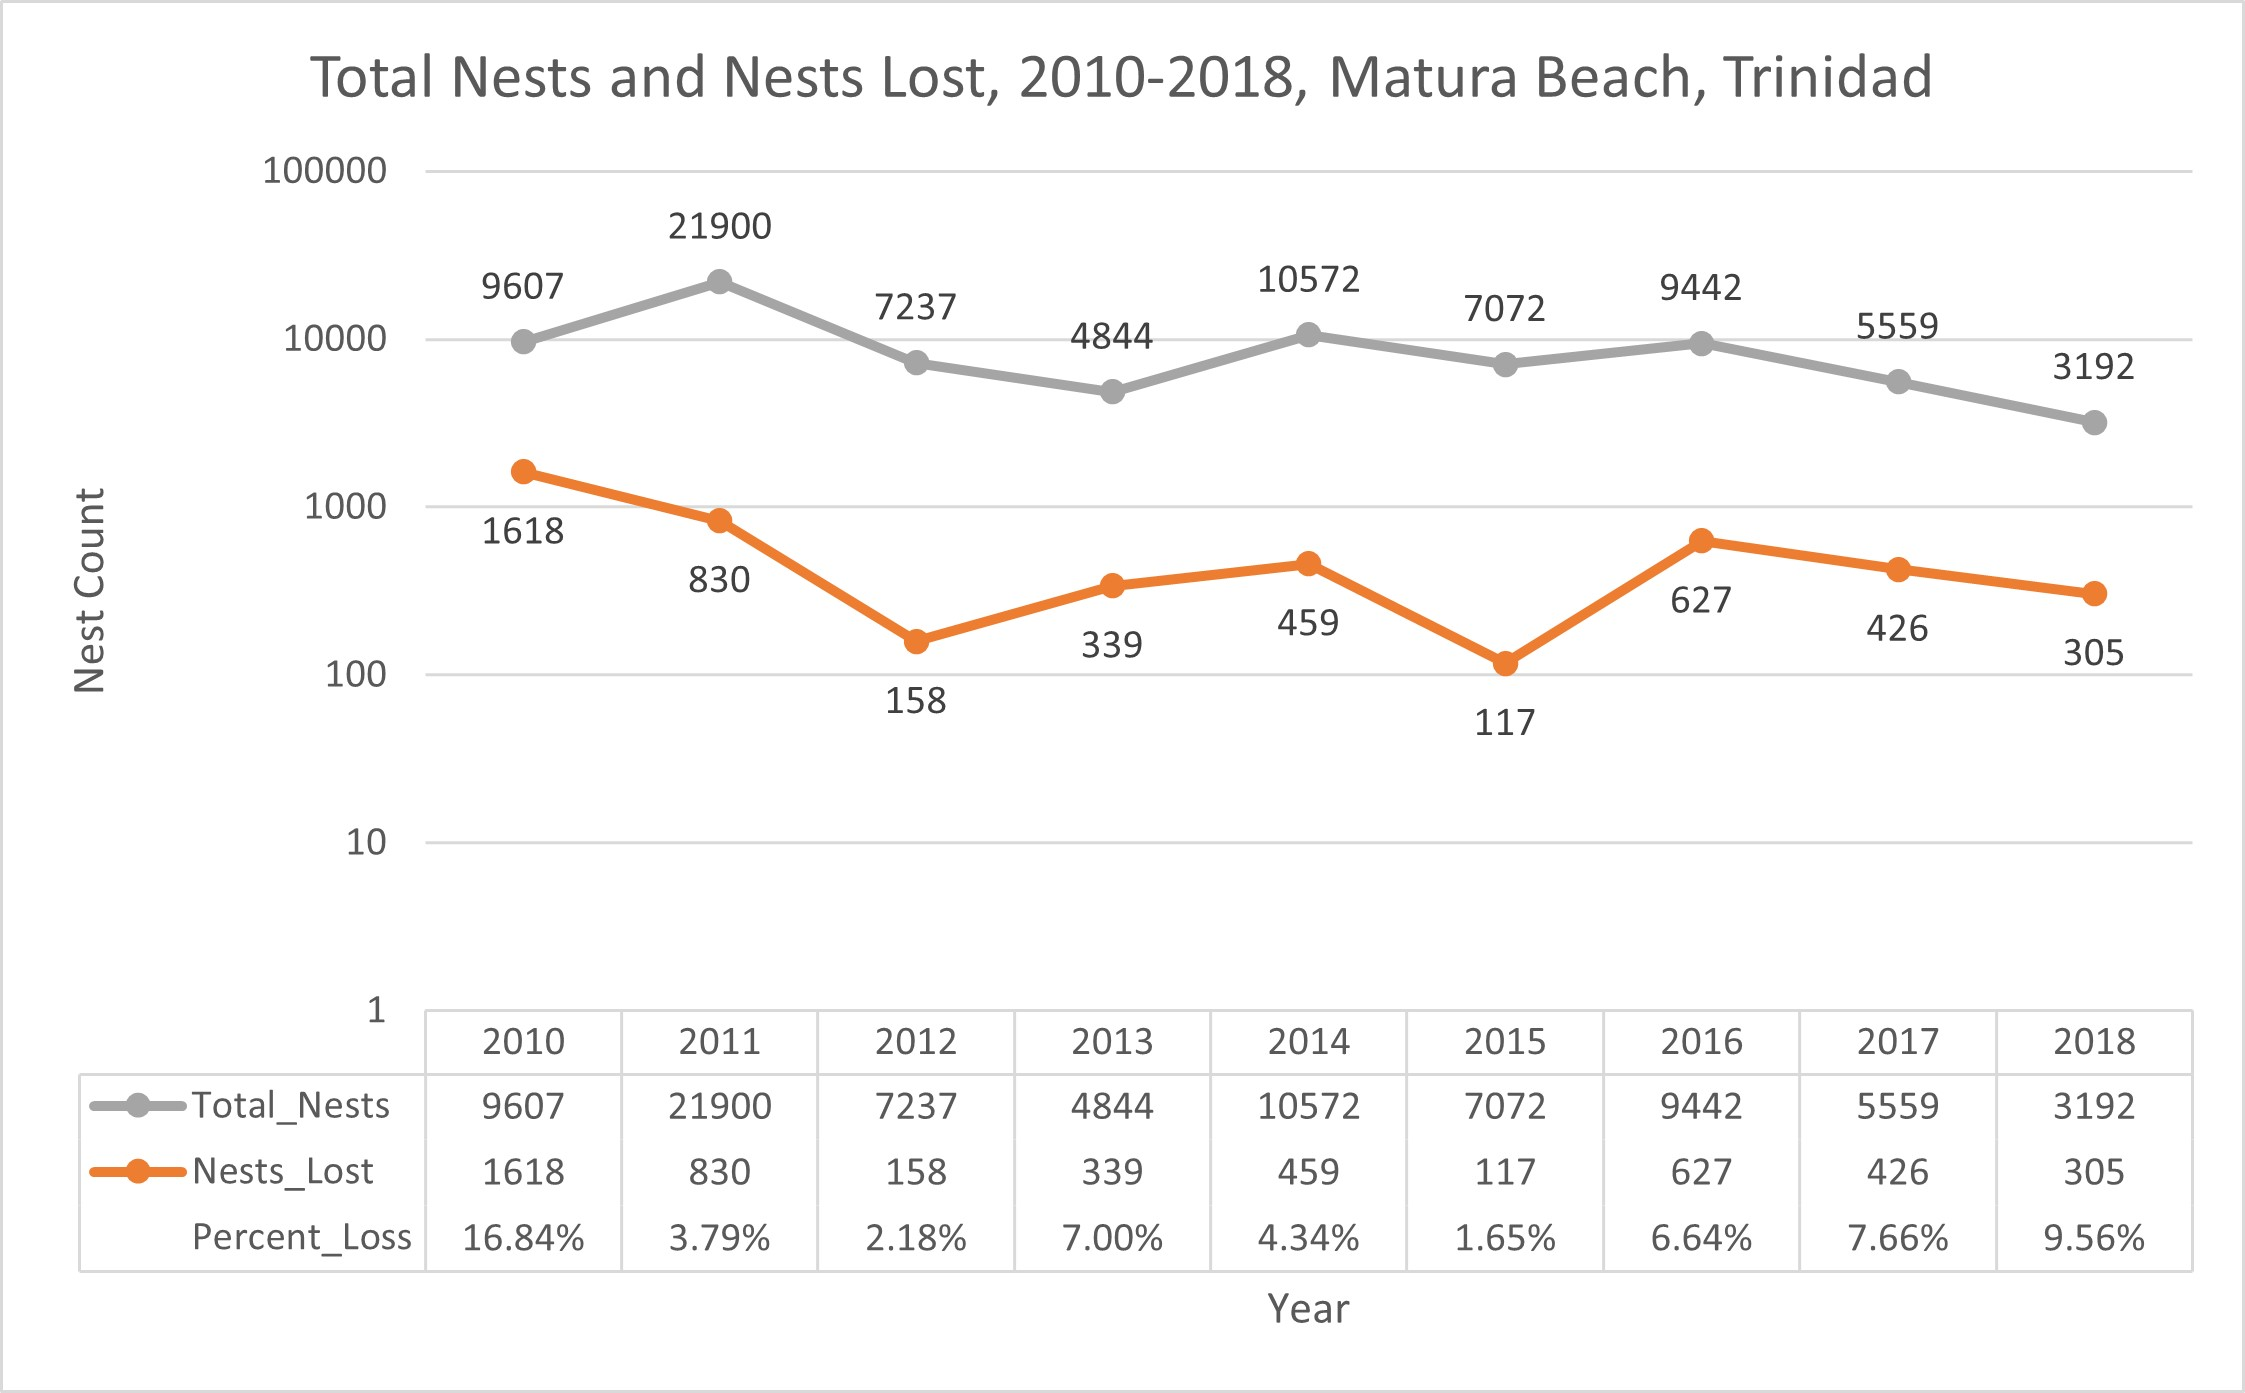

In [36]:
Image(filename='Loss_Graph.jpg')